In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import sklearn
import src.common as common
import src.ranking as ranking
import src.data_loading as data_loading
import src.data_transformation as data_transformation
import src.user_profile as user_profile
import src.test as test
import traceback


In [2]:
data_loader = data_loading.DataLoader('../data')
movies_df = data_loader.load_movies()
ratings_df = data_loader.load_ratings()

In [3]:
# split the data into train and test sets
train_set, test_set, test_user_ids = test.RankingTest.split_ratings_into_train_test(ratings_df.copy())
movie_rec_df = data_transformation.DataTransformer.transform_data(movies_df.copy(), train_set)
results = []
# i = 0
# user_profiles = user_profile.UserProfileCreator.build_user_profiles(movie_rec_df, train_set)
# user_profiles.head()
# for user_id in sorted(test_user_ids):
#     try:
#         user_ratings = test_set[test_set['userId'] == user_id]
#         train_user_ratings, test_user_ratings = test.RankingTest.split_user_ratings(user_ratings, n=0.1, k=10)
#         test_user_profile = user_profile.UserProfileCreator.build_user_profile(movie_rec_df, train_user_ratings)
#         ranking_df = ranking.RankingCreator.create_ranking(test_user_profile, movie_rec_df)
#         # filter ranking_df so that it only includes movie_id from test user ratings
#         test_movie_ids = test_user_ratings['movieId'].unique()
#         filtered_ranking_df = ranking_df[ranking_df.index.isin(test_movie_ids)]
#         results.append(test.RankingTest.calculate_spearman_corr(test_user_ratings.sort_values(by='rating', ascending=False), filtered_ranking_df))
#         i+=1
#         if i == 1000:
#             break
#     except Exception as e:
#         print(f"Error processing user {user_id}: {e}")
#         print(traceback.format_exc())
#         continue

In [4]:
from src.models import AprioriKmeansRecommender, AprioriSimplestRecommender

model = AprioriKmeansRecommender(movie_rec_df, min_support=0.1, k=21, min_confidence=0.5)
simple_recommender = AprioriSimplestRecommender(movie_rec_df, min_support=0.1, min_confidence=0.5)
model.fit(train_set)
model.get_rules()


{0:                antecedents             consequents  antecedent support  \
 0              (Adventure)                (Action)            0.472753   
 1                 (Action)             (Adventure)            0.429989   
 2                 (Sci-Fi)                (Action)            0.281726   
 3               (Thriller)                (Action)            0.214845   
 4              (Animation)             (Adventure)            0.204102   
 5               (Children)             (Adventure)            0.189809   
 6                (Fantasy)             (Adventure)            0.241934   
 7                 (Sci-Fi)             (Adventure)            0.281726   
 8              (Animation)              (Children)            0.204102   
 9               (Children)             (Animation)            0.189809   
 10             (Animation)                (Comedy)            0.204102   
 11              (Children)                (Comedy)            0.189809   
 12     (Adventure, Sc

In [5]:
test_user_ratings = test_set[test_set['userId'] == min(test_user_ids[test_user_ids != 0])]
recommendations = model.recommend_for_user(test_user_ratings, top_n=10)

C:\Data\Studia\magisterka\semestr_8\data-mining-project\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


In [6]:
movies_df[movies_df['movieId'].isin(recommendations)]

,movieId,title,genres


In [7]:
movies_df[movies_df['movieId'].isin(test_user_ratings['movieId'])]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
10,11,"American President, The (1995)",Comedy|Drama|Romance
...,...,...,...
4868,4973,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy|Romance
4874,4979,"Royal Tenenbaums, The (2001)",Comedy|Drama
4888,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
4890,4995,"Beautiful Mind, A (2001)",Drama|Romance


In [8]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
res = []
res_penalize = []
res_simple = []
res_simple_penalize= []
i = 0
for test_user in test_user_ids:
    test_user_ratings = test_set[test_set['userId'] == test_user]
    prediction_ratings, evaluation_ratings = test.RankingTest.split_user_ratings(test_user_ratings)
    recommendations = model.recommend_for_user(prediction_ratings, evaluation_ratings, top_n=10)
    corr = test.RankingTest.calculate_spearman_corr(evaluation_ratings, recommendations)
    res.append(corr)
    recommendations = model.recommend_for_user(prediction_ratings, evaluation_ratings, top_n=10, penalize_genres=True)
    corr = test.RankingTest.calculate_spearman_corr(evaluation_ratings, recommendations)
    res_penalize.append(corr)
    recommendations = simple_recommender.recommend_for_user(prediction_ratings, evaluation_ratings, top_n=10, penalize_genres=False)
    corr = test.RankingTest.calculate_spearman_corr(evaluation_ratings, recommendations)
    res_simple.append(corr)
    recommendations = simple_recommender.recommend_for_user(prediction_ratings, evaluation_ratings, top_n=10, penalize_genres=True)
    corr = test.RankingTest.calculate_spearman_corr(evaluation_ratings, recommendations)
    res_simple_penalize.append(corr)
    i += 1
    if i > 1000:
        break


C:\Data\Studia\magisterka\semestr_8\data-mining-project\src\test.py:115: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  merged.at[merged.index[0], 'rating'] = 1
C:\Data\Studia\magisterka\semestr_8\data-mining-project\src\test.py:115: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  merged.at[merged.index[0], 'rating'] = 1
C:\Data\Studia\magisterka\semestr_8\data-mining-project\src\test.py:115: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  merged.at[merged.index[0], 'rating'] = 

KeyboardInterrupt: 

In [9]:
res = [r for r in res if r > 0]
res_penalize = [r for r in res_penalize if r > 0]
res_simple = [r for r in res_simple if r > 0]
res_simple_penalize = [r for r in res_simple_penalize if r > 0]

<Axes: ylabel='Count'>

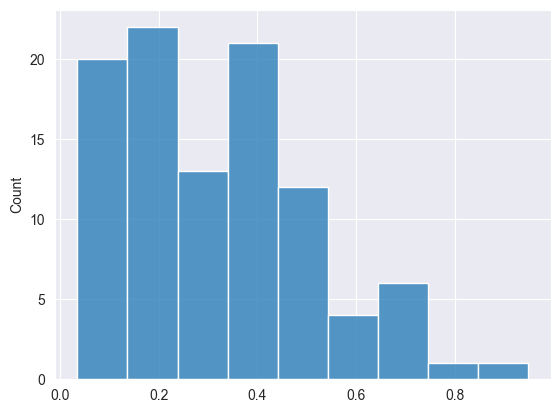

In [10]:
sns.histplot(res)

<Axes: ylabel='Count'>

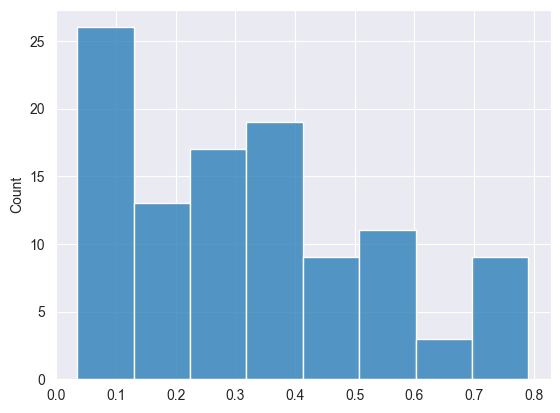

In [11]:
sns.histplot(res_penalize)

<Axes: ylabel='Count'>

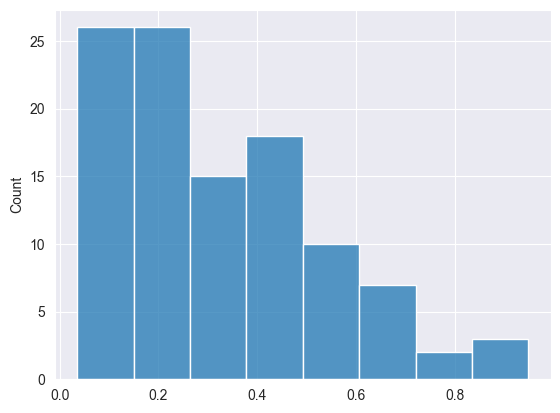

In [12]:
sns.histplot(res_simple)

<Axes: ylabel='Count'>

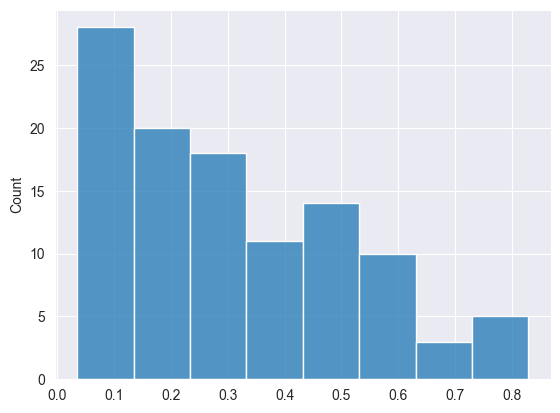

In [13]:
sns.histplot(res_simple_penalize)

In [15]:
print('Apriori Kmeans', np.mean(res))
print('Apriori Kmeans Pen', np.mean(res_penalize))
print('Apriori Simple', np.mean(res_simple))
print('Apriori Simple Pen', np.mean(res_simple_penalize))

Apriori Kmeans 0.32101465908977156
Apriori Kmeans Pen 0.3241556743683705
Apriori Simple 0.318445469215286
Apriori Simple Pen 0.3115907459064774
